In [1]:
#2nd model
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import airy
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
plt.style.use('dark_background')

# Parameters
L = 4000
hbar = 1
x0 = 200 
k0_values = [0.0, 0.1, 0.2] 
E_values = np.sin(k0_values)
dt = 0.05
sigma = 20 
frames = 70000
x = np.arange(L)
dx = 1
a = 700
t_max = 2
x_horizon = 1500 + a*np.arctanh(1/t_max) # Horizon position
horizon_interaction_width = 50  # Spatial width around horizon for interaction
dwell_threshold = 50  # Distance from horizon to consider "dwelling"

results = {} # Storage for results for all k0 values

In [2]:
#Main Simulation Loop for each k0
for k0 in k0_values:
    psi = np.exp(-((x - x0)**2) / (2 * sigma**2)) * np.exp(1j * k0 * (x - x0)) # Initial wavefunction
    psi /= np.sqrt(np.sum(np.abs(psi)**2 * dx))  # Normalize
    
    # Storage for current k0
    x_c_list = []  # Wave packet center (numerical)
    time_list = []
    vg_num_list = []
    probability_list = []
    
    # Dwell time tracking
    in_dwell_region = False
    dwell_start_time = None
    dwell_end_time = None
    dwell_entries = []  # Track all entries/exits
    current_dwell_start = None
    
    # RK4 integration
    for frame in range(frames):
        current_time = frame * dt
        
        # Track wave packet center
        total_density = np.abs(psi)**2
        x_c = np.sum(x * total_density) / np.sum(total_density)
        x_c_list.append(x_c)
        time_list.append(current_time)
        
        # Track total probability
        total_prob = np.sum(np.abs(psi)**2) * dx
        probability_list.append(total_prob)
        
        # Track dwell time at horizon
        distance_to_horizon = abs(x_c - x_horizon)
        
        if distance_to_horizon < dwell_threshold:
            if not in_dwell_region: # Inside dwell region
                in_dwell_region = True # Just entered dwell region
                current_dwell_start = current_time
                if dwell_start_time is None:
                    dwell_start_time = current_time  # First entry
        else:
            if in_dwell_region: # Outside dwell region
                in_dwell_region = False # Just exited dwell region
                dwell_end_time = current_time  # Last exit
                if current_dwell_start is not None:
                    dwell_entries.append((current_dwell_start, current_time))
                    current_dwell_start = None
        
        
        V_norm = np.tanh((x0 - x_horizon)/a)  # normalization factor
        V = t_max * (np.tanh((x - x_horizon)/a) - V_norm) / (1 - V_norm) # Tilt profile
        alpha = (1 - V)
        beta = hbar**2 * (1/8 + V/6)
        
        # RK4 integration
        # Stage 1: Compute k1
        dpsi_dx = np.zeros(L, dtype=complex)
        dpsi_dx[1:-1] = (psi[2:] - psi[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi[1] - psi[-1]) / (2 * dx)      # Periodic BC
        dpsi_dx[-1] = (psi[0] - psi[-2]) / (2 * dx)  

        d3psi_dx3 = np.zeros(L, dtype=complex)
        d3psi_dx3[2:-2] = (psi[4:] - 2*psi[3:-1] + 2*psi[1:-3] - psi[:-4]) / (2*dx**3)
        d3psi_dx3[0] = (psi[2] - 2*psi[1] + 2*psi[-1] - psi[-2]) / (2*dx**3)
        d3psi_dx3[1] = (psi[3] - 2*psi[2] + 2*psi[0] - psi[-1]) / (2*dx**3)
        d3psi_dx3[-1] = (psi[1] - 2*psi[0] + 2*psi[-2] - psi[-3]) / (2*dx**3)
        d3psi_dx3[-2] = (psi[0] - 2*psi[-1] + 2*psi[-3] - psi[-4]) / (2*dx**3)

        k1 = -alpha * dpsi_dx + beta * d3psi_dx3

        # Stage 2: Compute k2
        psi_temp = psi + 0.5 * dt * k1
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        d3psi_dx3[2:-2] = (psi_temp[4:] - 2*psi_temp[3:-1] + 2*psi_temp[1:-3] - psi_temp[:-4]) / (2*dx**3)
        d3psi_dx3[0] = (psi_temp[2] - 2*psi_temp[1] + 2*psi_temp[-1] - psi_temp[-2]) / (2*dx**3)
        d3psi_dx3[1] = (psi_temp[3] - 2*psi_temp[2] + 2*psi_temp[0] - psi_temp[-1]) / (2*dx**3)
        d3psi_dx3[-1] = (psi_temp[1] - 2*psi_temp[0] + 2*psi_temp[-2] - psi_temp[-3]) / (2*dx**3)
        d3psi_dx3[-2] = (psi_temp[0] - 2*psi_temp[-1] + 2*psi_temp[-3] - psi_temp[-4]) / (2*dx**3)
        k2 = -alpha * dpsi_dx + beta * d3psi_dx3

        # Stage 3: Compute k3
        psi_temp = psi + 0.5 * dt * k2
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        d3psi_dx3[2:-2] = (psi_temp[4:] - 2*psi_temp[3:-1] + 2*psi_temp[1:-3] - psi_temp[:-4]) / (2*dx**3)
        d3psi_dx3[0] = (psi_temp[2] - 2*psi_temp[1] + 2*psi_temp[-1] - psi_temp[-2]) / (2*dx**3)
        d3psi_dx3[1] = (psi_temp[3] - 2*psi_temp[2] + 2*psi_temp[0] - psi_temp[-1]) / (2*dx**3)
        d3psi_dx3[-1] = (psi_temp[1] - 2*psi_temp[0] + 2*psi_temp[-2] - psi_temp[-3]) / (2*dx**3)
        d3psi_dx3[-2] = (psi_temp[0] - 2*psi_temp[-1] + 2*psi_temp[-3] - psi_temp[-4]) / (2*dx**3)
        k3 = -alpha * dpsi_dx + beta * d3psi_dx3

        # Stage 4: Compute k4
        psi_temp = psi + dt * k3
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        d3psi_dx3[2:-2] = (psi_temp[4:] - 2*psi_temp[3:-1] + 2*psi_temp[1:-3] - psi_temp[:-4]) / (2*dx**3)
        d3psi_dx3[0] = (psi_temp[2] - 2*psi_temp[1] + 2*psi_temp[-1] - psi_temp[-2]) / (2*dx**3)
        d3psi_dx3[1] = (psi_temp[3] - 2*psi_temp[2] + 2*psi_temp[0] - psi_temp[-1]) / (2*dx**3)
        d3psi_dx3[-1] = (psi_temp[1] - 2*psi_temp[0] + 2*psi_temp[-2] - psi_temp[-3]) / (2*dx**3)
        d3psi_dx3[-2] = (psi_temp[0] - 2*psi_temp[-1] + 2*psi_temp[-3] - psi_temp[-4]) / (2*dx**3)
        k4 = -alpha * dpsi_dx + beta * d3psi_dx3

        psi = psi + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4) # RK4 Update
        
        # Normalize occasionally - COMMENTED OUT for non-Hermitian evolution
        #if frame % 100 == 0:
        #    psi /= np.sqrt(np.sum(np.abs(psi)**2 * dx))
        
        if len(x_c_list) > 1:
            vg_num = (x_c_list[-1] - x_c_list[-2]) / dt
            vg_num_list.append(vg_num)
    
    if in_dwell_region and current_dwell_start is not None: # If still in dwell region at end, close the interval
        dwell_entries.append((current_dwell_start, current_time))
    
    total_dwell_time = sum([exit_t - enter_t for enter_t, exit_t in dwell_entries]) # Calculate total dwell time from all entries
    
    # Store results for this k0
    results[k0] = {
        'x_c_list': x_c_list,
        'time_list': time_list,
        'final_psi': psi.copy(),
        'vg_num': vg_num_list,
        'dwell_time': total_dwell_time,
        'dwell_start': dwell_start_time,
        'dwell_end': dwell_end_time,
        'dwell_entries': dwell_entries,
        'still_dwelling': in_dwell_region,
        'probability_list': probability_list
    }

In [3]:
# Reflection/Transmission Analysis
colors = ['cyan', 'lime', 'magenta']
T_values = []
R_values = []
Loss_values = []

for i, k0 in enumerate(k0_values):
    final_density = np.abs(results[k0]['final_psi'])**2
    horizon_idx = np.argmin(np.abs(x - x_horizon)) # Find horizon index
    
    # Split regions at horizon
    transmission_region = x > x_horizon
    reflection_region = x < x_horizon
    
    # Calculate probabilities
    P_transmitted = np.sum(final_density[transmission_region]) * dx
    P_reflected = np.sum(final_density[reflection_region]) * dx
    P_total_final = P_transmitted + P_reflected
    
    P_initial = 1.0 # Initial probability (before evolution)
    
    # Proper Reflection/Transmission/Loss coefficients
    T = P_transmitted / P_initial
    R = P_reflected / P_initial
    Loss = 1.0 - (R + T)
    
    T_values.append(T)
    R_values.append(R)
    Loss_values.append(Loss)
    
    # Print results
    print(f"k0 = {k0:.1f}:")
    print(f"  Reflection (R) = {R:.6f}")
    print(f"  Transmission (T) = {T:.6f}")
    print(f"  Loss (1 - R - T) = {Loss:.6f}")
    print(f"  R + T + Loss = {R + T + Loss:.6f}")
    print(f"  Total probability (final) = {P_total_final:.6f}")
    print()

# Dwell Time Analysis
print(f"Dwell threshold: ±{dwell_threshold} from horizon (x_h = {x_horizon:.2f})")
print()

dwell_times = []
for k0 in k0_values:
    dwell_time = results[k0]['dwell_time']
    dwell_start = results[k0]['dwell_start']
    dwell_end = results[k0]['dwell_end']
    dwell_entries = results[k0]['dwell_entries']
    still_dwelling = results[k0]['still_dwelling']
    dwell_times.append(dwell_time)
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Total dwell time: {dwell_time:.2f}")
    print(f"  Number of horizon passages: {len(dwell_entries)}")
    
    if len(dwell_entries) > 0:
        for i, (enter_t, exit_t) in enumerate(dwell_entries):
            print(f"    Passage {i+1}: entered at t={enter_t:.2f}, exited at t={exit_t:.2f}, duration={exit_t-enter_t:.2f}")
    
    if dwell_start is None:
        print(f"  Never entered horizon region")
    
    if still_dwelling:
        print(f"  Still in horizon region at end of simulation")
    print()

k0 = 0.0:
  Reflection (R) = 0.009111
  Transmission (T) = 0.042385
  Loss (1 - R - T) = 0.948504
  R + T + Loss = 1.000000
  Total probability (final) = 0.051496

k0 = 0.1:
  Reflection (R) = 0.000190
  Transmission (T) = 0.148866
  Loss (1 - R - T) = 0.850944
  R + T + Loss = 1.000000
  Total probability (final) = 0.149056

k0 = 0.2:
  Reflection (R) = 0.000000
  Transmission (T) = 0.338769
  Loss (1 - R - T) = 0.661231
  R + T + Loss = 1.000000
  Total probability (final) = 0.338769

Dwell threshold: ±50 from horizon (x_h = 1884.51)

k0 = 0.0:
  Total dwell time: 484.65
  Number of horizon passages: 1
    Passage 1: entered at t=2732.15, exited at t=3216.80, duration=484.65

k0 = 0.1:
  Total dwell time: 258.60
  Number of horizon passages: 1
    Passage 1: entered at t=2430.05, exited at t=2688.65, duration=258.60

k0 = 0.2:
  Total dwell time: 188.50
  Number of horizon passages: 1
    Passage 1: entered at t=2229.90, exited at t=2418.40, duration=188.50



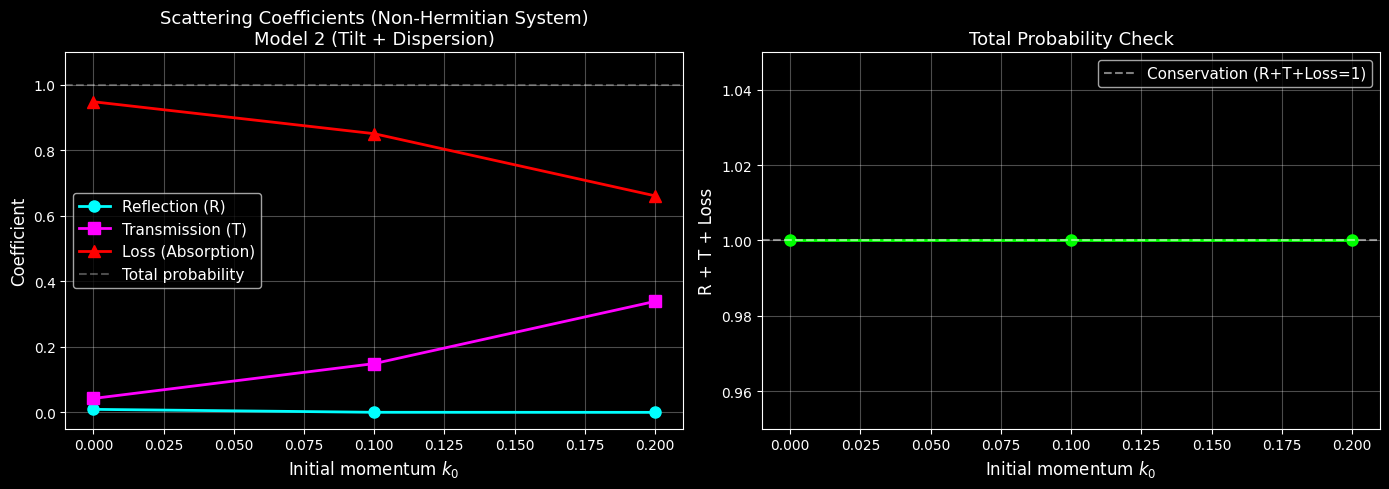

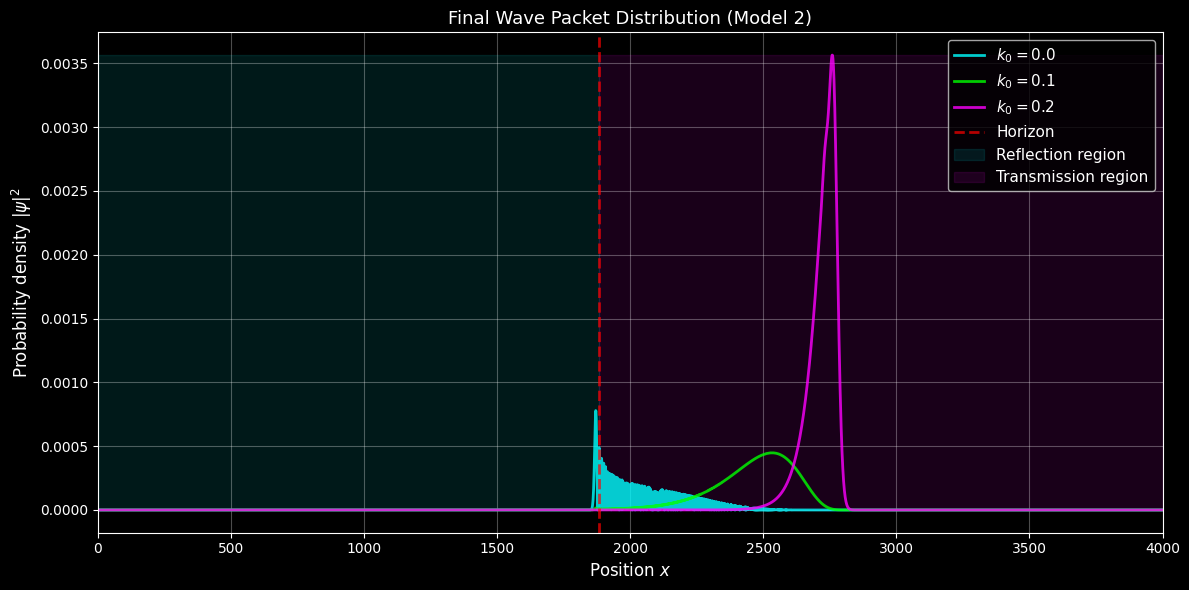

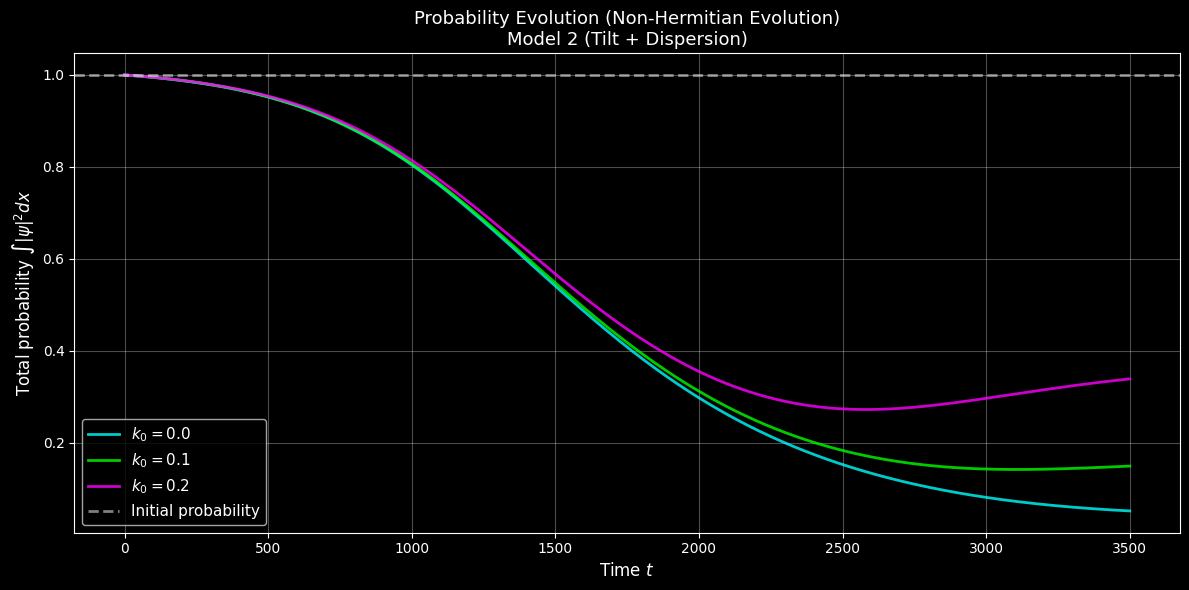

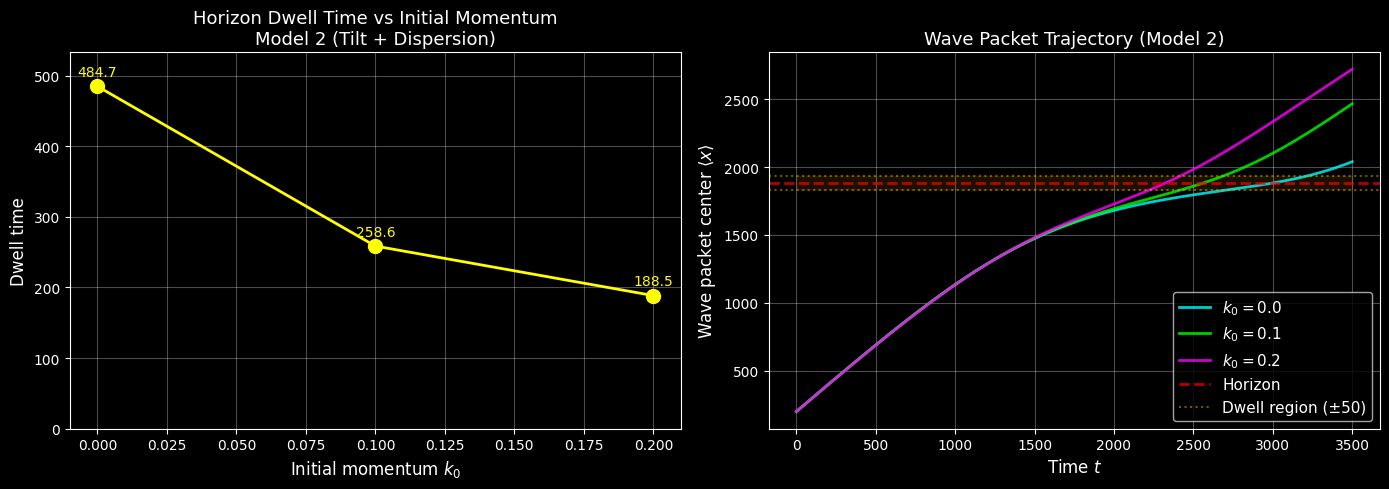


===== Horizon Properties =====
Horizon position: x_h = 1884.51

===== Non-Hermitian Absorption Summary =====
Model 2 probability loss characteristics:
  k0 = 0.0: 94.9% absorbed
  k0 = 0.1: 85.1% absorbed
  k0 = 0.2: 66.1% absorbed


In [4]:
# ===== Plotting R, T, and Loss vs k0 =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R, T, and Loss vs k0
ax1.plot(k0_values, R_values, 'o-', color='cyan', linewidth=2, markersize=8, label='Reflection (R)')
ax1.plot(k0_values, T_values, 's-', color='magenta', linewidth=2, markersize=8, label='Transmission (T)')
ax1.plot(k0_values, Loss_values, '^-', color='red', linewidth=2, markersize=8, label='Loss (Absorption)')
ax1.axhline(y=1.0, color='white', linestyle='--', alpha=0.3, label='Total probability')
ax1.set_xlabel('Initial momentum $k_0$', fontsize=12)
ax1.set_ylabel('Coefficient', fontsize=12)
ax1.set_title('Scattering Coefficients (Non-Hermitian System)\nModel 2 (Tilt + Dispersion)', fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)
ax1.set_ylim([-0.05, 1.1])

# Plot 2: R + T + Loss (should equal 1)
sum_all = np.array(R_values) + np.array(T_values) + np.array(Loss_values)
ax2.plot(k0_values, sum_all, 'o-', color='lime', linewidth=2, markersize=8)
ax2.axhline(y=1.0, color='white', linestyle='--', alpha=0.5, label='Conservation (R+T+Loss=1)')
ax2.set_xlabel('Initial momentum $k_0$', fontsize=12)
ax2.set_ylabel('R + T + Loss', fontsize=12)
ax2.set_title('Total Probability Check', fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)
ax2.set_ylim([0.95, 1.05])

plt.tight_layout()
plt.savefig('model2_scattering_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== Final Wavefunction Spatial Distribution =====
fig, ax = plt.subplots(figsize=(12, 6))

for i, k0 in enumerate(k0_values):
    final_density = np.abs(results[k0]['final_psi'])**2
    ax.plot(x, final_density, color=colors[i], linewidth=2, label=f'$k_0 = {k0:.1f}$', alpha=0.8)

# Mark horizon
ax.axvline(x=x_horizon, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Horizon')
ax.fill_betweenx([0, np.max([np.max(np.abs(results[k0]['final_psi'])**2) for k0 in k0_values])], 0, x_horizon, color='cyan', alpha=0.1, label='Reflection region')
ax.fill_betweenx([0, np.max([np.max(np.abs(results[k0]['final_psi'])**2) for k0 in k0_values])], x_horizon, L, color='magenta', alpha=0.1, label='Transmission region')

ax.set_xlabel('Position $x$', fontsize=12)
ax.set_ylabel('Probability density $|\\psi|^2$', fontsize=12)
ax.set_title('Final Wave Packet Distribution (Model 2)', fontsize=13)
ax.legend(fontsize=11, loc='upper right')
ax.grid(alpha=0.3)
ax.set_xlim([0, L])

plt.tight_layout()
plt.savefig('model2_final_wavefunction.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== Probability Evolution Over Time =====
fig, ax = plt.subplots(figsize=(12, 6))

for i, k0 in enumerate(k0_values):
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    ax.plot(time_array, prob_array, color=colors[i], linewidth=2, 
            label=f'$k_0 = {k0:.1f}$', alpha=0.8)

ax.axhline(y=1.0, color='white', linestyle='--', linewidth=2, alpha=0.5, label='Initial probability')
ax.set_xlabel('Time $t$', fontsize=12)
ax.set_ylabel('Total probability $\\int|\\psi|^2 dx$', fontsize=12)
ax.set_title('Probability Evolution (Non-Hermitian Evolution)\nModel 2 (Tilt + Dispersion)', fontsize=13)
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model2_probability_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== Dwell Time Visualization =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Dwell time vs k0
ax1.plot(k0_values, dwell_times, 'o-', color='yellow', linewidth=2, markersize=10)
ax1.set_xlabel('Initial momentum $k_0$', fontsize=12)
ax1.set_ylabel('Dwell time', fontsize=12)
ax1.set_title('Horizon Dwell Time vs Initial Momentum\nModel 2 (Tilt + Dispersion)', fontsize=13)
ax1.grid(alpha=0.3)
ax1.set_ylim([0, max(dwell_times) * 1.1 if dwell_times else 1])

# Add text annotations
for i, (k0, dwell) in enumerate(zip(k0_values, dwell_times)):
    ax1.text(k0, dwell + (max(dwell_times) if dwell_times else 1)*0.03, f'{dwell:.1f}', 
             ha='center', fontsize=10, color='yellow')

# Plot 2: Trajectory showing dwell region
for i, k0 in enumerate(k0_values):
    x_c_array = np.array(results[k0]['x_c_list'])
    time_array = np.array(results[k0]['time_list'])
    ax2.plot(time_array, x_c_array, color=colors[i], linewidth=2, 
             label=f'$k_0 = {k0:.1f}$', alpha=0.8)

# Mark horizon and dwell region
ax2.axhline(y=x_horizon, color='red', linestyle='--', linewidth=2, 
            alpha=0.7, label='Horizon')
ax2.axhline(y=x_horizon + dwell_threshold, color='orange', linestyle=':', 
            linewidth=1.5, alpha=0.5, label=f'Dwell region (±{dwell_threshold})')
ax2.axhline(y=x_horizon - dwell_threshold, color='orange', linestyle=':', 
            linewidth=1.5, alpha=0.5)
ax2.fill_between(time_array, x_horizon - dwell_threshold, 
                  x_horizon + dwell_threshold, color='orange', alpha=0.1)

ax2.set_xlabel('Time $t$', fontsize=12)
ax2.set_ylabel('Wave packet center $\\langle x \\rangle$', fontsize=12)
ax2.set_title('Wave Packet Trajectory (Model 2)', fontsize=13)
ax2.legend(fontsize=11, loc='best')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model2_dwell_time.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n===== Horizon Properties =====")
print(f"Horizon position: x_h = {x_horizon:.2f}")
print("\n===== Non-Hermitian Absorption Summary =====")
print(f"Model 2 probability loss characteristics:")
for k0, loss in zip(k0_values, Loss_values):
    print(f"  k0 = {k0:.1f}: {loss*100:.1f}% absorbed")

In [5]:
# Absorption Rate Analysis
print("Absorption Rate Analysis")

all_dP_dt = {} # Storage for all k0 data

for k0 in k0_values:
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    
    dP_dt = np.gradient(prob_array, time_array) # Compute dP/dt numerically
    all_dP_dt[k0] = dP_dt
    
    # Find maximum absorption rate (most negative dP/dt)
    max_abs_rate_idx = np.argmin(dP_dt)
    max_abs_rate = dP_dt[max_abs_rate_idx]
    t_max_abs = time_array[max_abs_rate_idx]
    
    # Average absorption rate during dwell
    dwell_entries = results[k0]['dwell_entries']
    if len(dwell_entries) > 0:
        t_in, t_out = dwell_entries[0]
        dwell_mask = (time_array >= t_in) & (time_array <= t_out)
        avg_dwell_rate = np.mean(dP_dt[dwell_mask])
    else:
        avg_dwell_rate = 0
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Maximum absorption rate: {max_abs_rate:.6f} at t = {t_max_abs:.1f}")
    print(f"  Average rate during dwell: {avg_dwell_rate:.6f}")
    print()

Absorption Rate Analysis
k0 = 0.0:
  Maximum absorption rate: -0.000565 at t = 1415.0
  Average rate during dwell: -0.000099

k0 = 0.1:
  Maximum absorption rate: -0.000555 at t = 1408.1
  Average rate during dwell: -0.000138

k0 = 0.2:
  Maximum absorption rate: -0.000526 at t = 1388.2
  Average rate during dwell: -0.000121



Transit to Horizon Analysis
k0 = 0.0:
  Horizon arrival time: t = 3010
  Probability at arrival: P = 0.080014
  Loss during transit: 92.0%
  Max loss at: x = 1425.9, t = 1415
  (max loss BEFORE horizon arrival)

k0 = 0.1:
  Horizon arrival time: t = 2568
  Probability at arrival: P = 0.173147
  Loss during transit: 82.7%
  Max loss at: x = 1422.8, t = 1408
  (max loss BEFORE horizon arrival)

k0 = 0.2:
  Horizon arrival time: t = 2328
  Probability at arrival: P = 0.286406
  Loss during transit: 71.4%
  Max loss at: x = 1412.6, t = 1388
  (max loss BEFORE horizon arrival)

Maximum Absorption Locations
k0 = 0.0:
  Position: x = 1425.9
  Distance from horizon: Δx = 458.6
  Tilt at this point: V(x) = 0.412
  Loss rate: dP/dt = -0.000565

k0 = 0.1:
  Position: x = 1422.8
  Distance from horizon: Δx = 461.7
  Tilt at this point: V(x) = 0.409
  Loss rate: dP/dt = -0.000555

k0 = 0.2:
  Position: x = 1412.6
  Distance from horizon: Δx = 471.9
  Tilt at this point: V(x) = 0.399
  Loss rate: dP

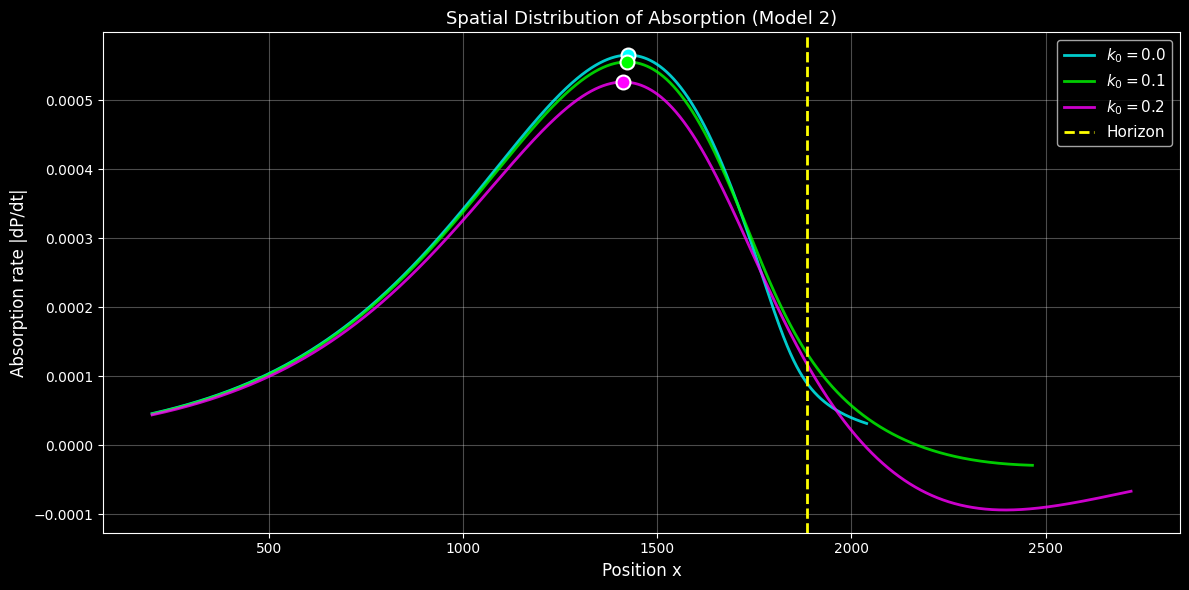

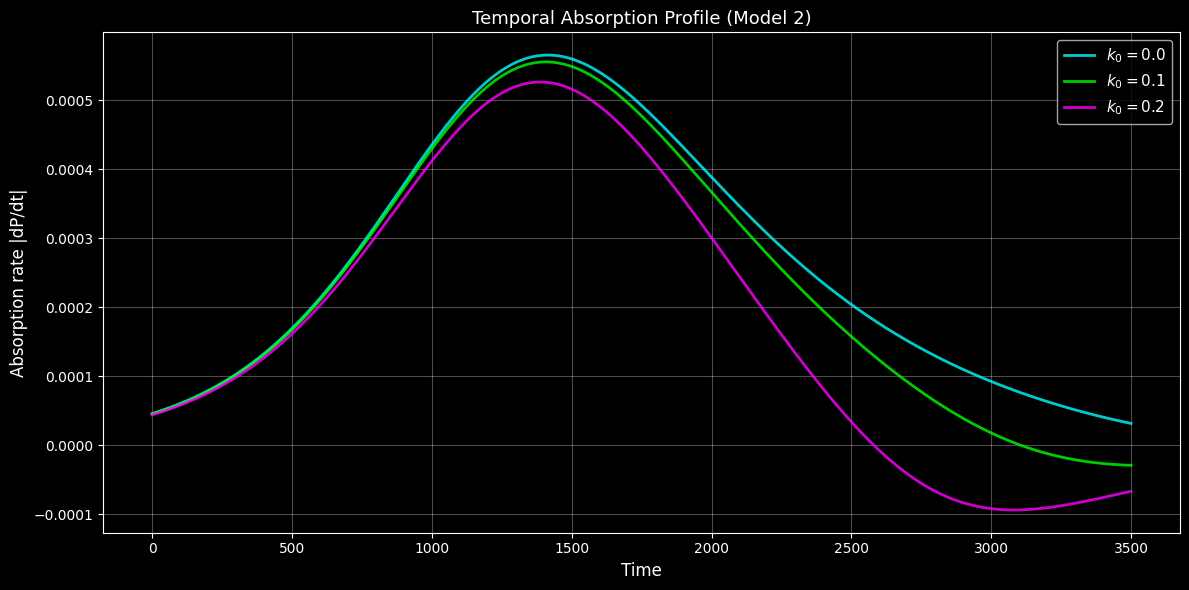

In [6]:
print("Transit to Horizon Analysis")
for k0 in k0_values:
    x_c_array = np.array(results[k0]['x_c_list'])
    time_array = np.array(results[k0]['time_list'])
    prob_array = np.array(results[k0]['probability_list'])
    
    horizon_idx = np.argmin(np.abs(x_c_array - x_horizon))
    t_arrival = time_array[horizon_idx]
    P_at_arrival = prob_array[horizon_idx]
    
    # Find maximum absorption rate location
    dP_dt = all_dP_dt[k0]
    max_loss_idx = np.argmin(dP_dt)
    t_max_loss = time_array[max_loss_idx]
    x_max_loss = x_c_array[max_loss_idx]
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Horizon arrival time: t = {t_arrival:.0f}")
    print(f"  Probability at arrival: P = {P_at_arrival:.6f}")
    print(f"  Loss during transit: {(1-P_at_arrival)*100:.1f}%")
    print(f"  Max loss at: x = {x_max_loss:.1f}, t = {t_max_loss:.0f}")
    
    if t_max_loss < t_arrival:
        print(f"  (max loss BEFORE horizon arrival)")
    elif t_max_loss > t_arrival + 500:
        print(f"  (max loss AFTER horizon interaction)")
    else:
        print(f"  (max loss DURING horizon interaction)")
    print()

# Detailed spatial analysis for all k0
print("Maximum Absorption Locations")
for k0 in k0_values:
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    x_c_array = np.array(results[k0]['x_c_list'])
    dP_dt = all_dP_dt[k0]
    
    # Key moments
    max_loss_idx = np.argmin(dP_dt)
    t_max_loss = time_array[max_loss_idx]
    x_max_loss = x_c_array[max_loss_idx]
    P_max_loss = prob_array[max_loss_idx]
    
    # Tilt at maximum loss position
    V_norm = np.tanh((x0 - x_horizon)/a)
    V_max_loss = t_max * (np.tanh((x_max_loss - x_horizon)/a) - V_norm) / (1 - V_norm)
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Position: x = {x_max_loss:.1f}")
    print(f"  Distance from horizon: Δx = {x_horizon - x_max_loss:.1f}")
    print(f"  Tilt at this point: V(x) = {V_max_loss:.3f}")
    print(f"  Loss rate: dP/dt = {dP_dt[max_loss_idx]:.6f}")
    print()

# Loss rate vs position for all k0 (parametric)
fig, ax = plt.subplots(figsize=(12, 6))
for i, k0 in enumerate(k0_values):
    x_c_array = np.array(results[k0]['x_c_list'])
    dP_dt = all_dP_dt[k0]
    ax.plot(x_c_array, -dP_dt, color=colors[i], linewidth=2, 
             label=f'$k_0 = {k0:.1f}$', alpha=0.8)
    
    # Mark maximum absorption point
    max_loss_idx = np.argmin(dP_dt)
    x_max = x_c_array[max_loss_idx]
    rate_max = -dP_dt[max_loss_idx]
    ax.plot(x_max, rate_max, 'o', color=colors[i], markersize=10, 
             markeredgecolor='white', markeredgewidth=1.5)

ax.axvline(x_horizon, color='yellow', linestyle='--', linewidth=2, label='Horizon')
ax.set_xlabel('Position x', fontsize=12)
ax.set_ylabel('Absorption rate |dP/dt|', fontsize=12)
ax.set_title('Spatial Distribution of Absorption (Model 2)', fontsize=13)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model2_absorption_comparison_all_k0.png', dpi=150)
plt.show()

# dP/dt vs time
fig, ax = plt.subplots(figsize=(12, 6))

for i, k0 in enumerate(k0_values):
    time_array = np.array(results[k0]['time_list'])
    dP_dt = all_dP_dt[k0]
    ax.plot(time_array, -dP_dt, color=colors[i], linewidth=2, 
            label=f'$k_0 = {k0:.1f}$', alpha=0.8)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Absorption rate |dP/dt|', fontsize=12)
ax.set_title('Temporal Absorption Profile (Model 2)', fontsize=13)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model2_absorption_vs_time.png', dpi=150)
plt.show()

In [7]:
for k0 in k0_values:
    dwell_entries = results[k0]['dwell_entries']
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    
    if len(dwell_entries) > 0:
        for j, (t_in, t_out) in enumerate(dwell_entries):
            # Find probability at dwell entry and exit
            idx_in = np.argmin(np.abs(time_array - t_in))
            idx_out = np.argmin(np.abs(time_array - t_out))
            P_in = prob_array[idx_in]
            P_out = prob_array[idx_out]
            
            print(f"k0 = {k0:.1f}, Dwell period {j+1}:")
            print(f"  Entry: t={t_in:.0f}, P={P_in:.6f}")
            print(f"  Exit: t={t_out:.0f}, P={P_out:.6f}")
            print(f"  Change: ΔP = {P_out - P_in:+.6f}")
            if P_out > P_in:
                print(f"  ⚠️ Probability GREW during dwell (unphysical!)")

# Check all three k0 values
for k0 in k0_values:
    dwell_entries = results[k0]['dwell_entries']
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    
    print(f"\n===== k0 = {k0:.1f} =====")
    print(f"Number of dwell periods: {len(dwell_entries)}")
    
    if len(dwell_entries) > 0:
        for j, (t_in, t_out) in enumerate(dwell_entries):
            idx_in = np.argmin(np.abs(time_array - t_in))
            idx_out = np.argmin(np.abs(time_array - t_out))
            P_in = prob_array[idx_in]
            P_out = prob_array[idx_out]
            duration = t_out - t_in
            
            print(f"Dwell period {j+1}:")
            print(f"  Duration: {duration:.0f}")
            print(f"  Entry: t={t_in:.0f}, P={P_in:.6f}")
            print(f"  Exit: t={t_out:.0f}, P={P_out:.6f}")
            print(f"  Change: ΔP = {P_out - P_in:+.6f} ({(P_out/P_in - 1)*100:+.1f}%)")
    else:
        print("  No dwell periods detected")

k0 = 0.0, Dwell period 1:
  Entry: t=2732, P=0.112279
  Exit: t=3217, P=0.064407
  Change: ΔP = -0.047872
k0 = 0.1, Dwell period 1:
  Entry: t=2430, P=0.194974
  Exit: t=2689, P=0.159343
  Change: ΔP = -0.035631
k0 = 0.2, Dwell period 1:
  Entry: t=2230, P=0.300559
  Exit: t=2418, P=0.277749
  Change: ΔP = -0.022810

===== k0 = 0.0 =====
Number of dwell periods: 1
Dwell period 1:
  Duration: 485
  Entry: t=2732, P=0.112279
  Exit: t=3217, P=0.064407
  Change: ΔP = -0.047872 (-42.6%)

===== k0 = 0.1 =====
Number of dwell periods: 1
Dwell period 1:
  Duration: 259
  Entry: t=2430, P=0.194974
  Exit: t=2689, P=0.159343
  Change: ΔP = -0.035631 (-18.3%)

===== k0 = 0.2 =====
Number of dwell periods: 1
Dwell period 1:
  Duration: 188
  Entry: t=2230, P=0.300559
  Exit: t=2418, P=0.277749
  Change: ΔP = -0.022810 (-7.6%)



GROUP VELOCITY DIAGNOSTIC ANALYSIS

--- Analysis for k0 = 0.0 ---
Allowed Region (x < 1835):
  Mean v_g = 0.598262 ± 0.304694
  Range: 0.165279 to 0.999803
  Time spent: 2732.05
Horizon Region (x = 1884.5143010338384 ± 50):
  Mean v_g = 0.206316 ± 0.035348
  Minimum v_g = 0.165758
  Range: 0.165758 to 0.286059
  Time spent: 484.60
  → SLOWS but continues (min v_g = 0.165758)
Forbidden Region (x > 1935):
  Mean v_g = 0.369682 ± 0.051435
  Range: 0.286084 to 0.462820
  Time spent: 283.15
  → SUCCESSFUL TRANSMISSION detected
Transmission Probability: T = 0.0424
Reflection Probability: R = 0.0091
  → WEAK TRANSMISSION (1% < T < 10%)

--- Analysis for k0 = 0.1 ---
Allowed Region (x < 1835):
  Mean v_g = 0.672635 ± 0.252918
  Range: 0.318400 to 0.998534
  Time spent: 2429.95
Horizon Region (x = 1884.5143010338384 ± 50):
  Mean v_g = 0.386694 ± 0.029968
  Minimum v_g = 0.341700
  Range: 0.341700 to 0.444500
  Time spent: 258.55
  → SLOWS but continues (min v_g = 0.341700)
Forbidden Region (x

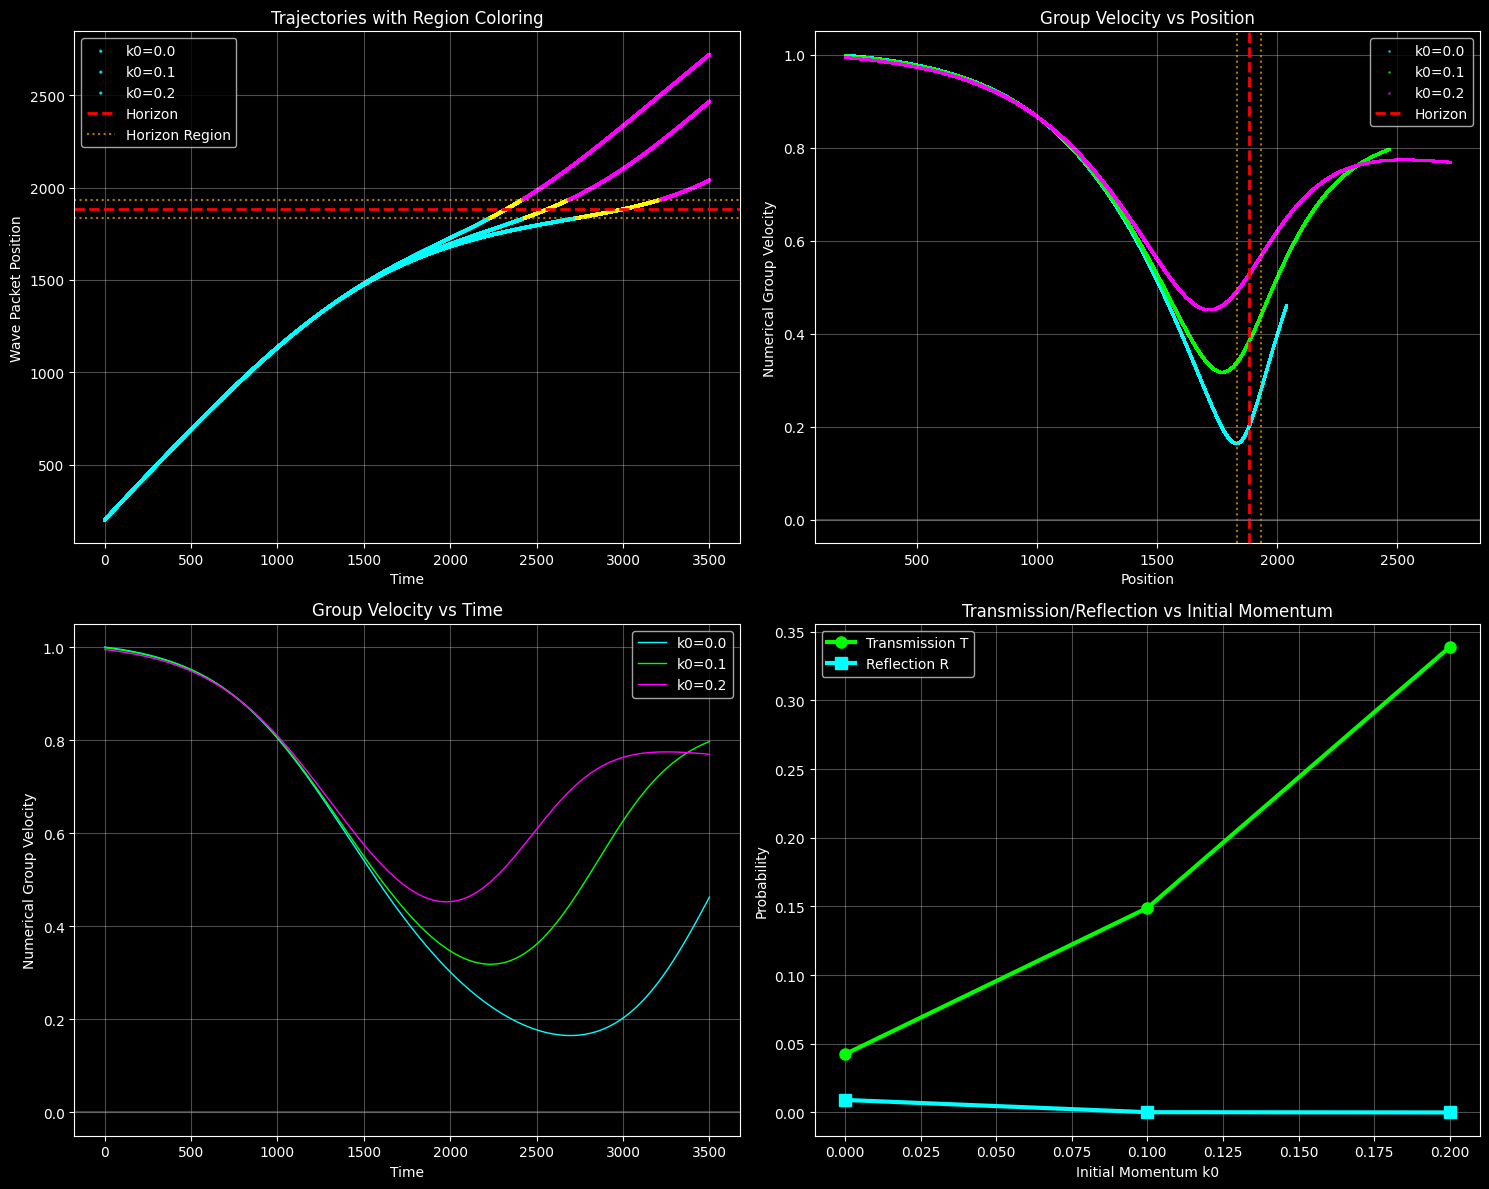


SUMMARY OF KEY FINDINGS:
Horizon position: x = 1884.5
Horizon region: x = 1884.5143010338384 ± 50

k0 = 0.0: T = 0.0424, R = 0.0091

k0 = 0.1: T = 0.1489, R = 0.0002

k0 = 0.2: T = 0.3388, R = 0.0000


In [8]:
#Group Velocity Diagnostic Analysis
print("\n" + "="*60)
print("GROUP VELOCITY DIAGNOSTIC ANALYSIS")
print("="*60)

for i, k0 in enumerate(k0_values):
    print(f"\n--- Analysis for k0 = {k0} ---")
    
    # Get numerical trajectory data
    x_c_list = results[k0]['x_c_list']
    time_list = results[k0]['time_list']
    vg_num_list = results[k0]['vg_num']
    
    # Define regions
    horizon_region = (x_horizon - horizon_interaction_width, x_horizon + horizon_interaction_width)
    allowed_region = (0, x_horizon - horizon_interaction_width)
    forbidden_region = (x_horizon + horizon_interaction_width, L)
    
    # Analyze group velocity in each region
    vg_allowed = []
    vg_horizon = [] 
    vg_forbidden = []
    times_allowed = []
    times_horizon = []
    times_forbidden = []
    
    for j, (x_pos, time_val) in enumerate(zip(x_c_list[1:], time_list[1:])):
        if j < len(vg_num_list):
            vg = vg_num_list[j]
            
            if allowed_region[0] <= x_pos <= allowed_region[1]:
                vg_allowed.append(vg)
                times_allowed.append(time_val)
            elif horizon_region[0] <= x_pos <= horizon_region[1]:
                vg_horizon.append(vg)
                times_horizon.append(time_val)
            elif forbidden_region[0] <= x_pos <= forbidden_region[1]:
                vg_forbidden.append(vg)
                times_forbidden.append(time_val)
    
    # Calculate statistics
    if vg_allowed:
        vg_allowed_mean = np.mean(vg_allowed)
        vg_allowed_std = np.std(vg_allowed)
        print(f"Allowed Region (x < {x_horizon-horizon_interaction_width:.0f}):")
        print(f"  Mean v_g = {vg_allowed_mean:.6f} ± {vg_allowed_std:.6f}")
        print(f"  Range: {min(vg_allowed):.6f} to {max(vg_allowed):.6f}")
        print(f"  Time spent: {max(times_allowed)-min(times_allowed) if times_allowed else 0:.2f}")
    
    if vg_horizon:
        vg_horizon_mean = np.mean(vg_horizon)
        vg_horizon_std = np.std(vg_horizon)
        vg_horizon_min = min(vg_horizon)
        print(f"Horizon Region (x = {x_horizon} ± {horizon_interaction_width}):")
        print(f"  Mean v_g = {vg_horizon_mean:.6f} ± {vg_horizon_std:.6f}")
        print(f"  Minimum v_g = {vg_horizon_min:.6f}")
        print(f"  Range: {min(vg_horizon):.6f} to {max(vg_horizon):.6f}")
        print(f"  Time spent: {max(times_horizon)-min(times_horizon) if times_horizon else 0:.2f}")
        
        # Check if wave packet actually stops or just slows down
        if abs(vg_horizon_min) < 1e-3:
            print(f"  → NEARLY STOPS at horizon (v_g ≈ {vg_horizon_min:.6f})")
        else:
            print(f"  → SLOWS but continues (min v_g = {vg_horizon_min:.6f})")
    
    if vg_forbidden:
        vg_forbidden_mean = np.mean(vg_forbidden)
        vg_forbidden_std = np.std(vg_forbidden)
        print(f"Forbidden Region (x > {x_horizon+horizon_interaction_width:.0f}):")
        print(f"  Mean v_g = {vg_forbidden_mean:.6f} ± {vg_forbidden_std:.6f}")
        print(f"  Range: {min(vg_forbidden):.6f} to {max(vg_forbidden):.6f}")
        print(f"  Time spent: {max(times_forbidden)-min(times_forbidden) if times_forbidden else 0:.2f}")
        
        # Check if transmission occurred
        if len(vg_forbidden) > 10:  # Significant time spent in forbidden region
            print(f"  → SUCCESSFUL TRANSMISSION detected")
    
    # Transmission analysis
    T = T_values[i]
    R = R_values[i]
    print(f"Transmission Probability: T = {T:.4f}")
    print(f"Reflection Probability: R = {R:.4f}")
    
    if T > 0.1:
        print(f"  → SIGNIFICANT TRANSMISSION (T > 10%)")
    elif T > 0.01:
        print(f"  → WEAK TRANSMISSION (1% < T < 10%)")
    else:
        print(f"  → PRIMARILY REFLECTION (T < 1%)")

# ===== Plot Group Velocity Analysis =====
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Trajectories with region coloring
ax1 = axes[0, 0]
for i, k0 in enumerate(k0_values):
    x_c_list = results[k0]['x_c_list']
    time_list = results[k0]['time_list']
    
    # Color code by region
    colors_regions = []
    for x_pos in x_c_list:
        if x_pos < x_horizon - horizon_interaction_width:
            colors_regions.append('cyan')  # Allowed
        elif x_pos > x_horizon + horizon_interaction_width:
            colors_regions.append('magenta')  # Forbidden  
        else:
            colors_regions.append('yellow')  # Horizon
    
    scatter = ax1.scatter(time_list, x_c_list, c=colors_regions, s=2, alpha=0.7, label=f'k0={k0}')
    
ax1.axhline(y=x_horizon, color='red', linestyle='--', linewidth=2, label='Horizon')
ax1.axhline(y=x_horizon - horizon_interaction_width, color='orange', linestyle=':', alpha=0.7, label='Horizon Region')
ax1.axhline(y=x_horizon + horizon_interaction_width, color='orange', linestyle=':', alpha=0.7)
ax1.set_xlabel('Time')
ax1.set_ylabel('Wave Packet Position')
ax1.set_title('Trajectories with Region Coloring')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Group velocity vs position
ax2 = axes[0, 1]
for i, k0 in enumerate(k0_values):
    x_c_list = results[k0]['x_c_list'][1:]  # Skip first point (no v_g)
    vg_num_list = results[k0]['vg_num']
    
    if len(vg_num_list) == len(x_c_list):
        ax2.scatter(x_c_list, vg_num_list, color=colors[i], s=1, alpha=0.6, label=f'k0={k0}')
    
ax2.axvline(x=x_horizon, color='red', linestyle='--', linewidth=2, label='Horizon')
ax2.axvline(x=x_horizon - horizon_interaction_width, color='orange', linestyle=':', alpha=0.7)
ax2.axvline(x=x_horizon + horizon_interaction_width, color='orange', linestyle=':', alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax2.set_xlabel('Position')
ax2.set_ylabel('Numerical Group Velocity')
ax2.set_title('Group Velocity vs Position')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Group velocity vs time
ax3 = axes[1, 0]
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list'][1:]  # Skip first point
    vg_num_list = results[k0]['vg_num']
    
    if len(vg_num_list) == len(time_list):
        ax3.plot(time_list, vg_num_list, color=colors[i], linewidth=1, label=f'k0={k0}')
    
ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax3.set_xlabel('Time')
ax3.set_ylabel('Numerical Group Velocity')
ax3.set_title('Group Velocity vs Time')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Transmission vs initial momentum
ax4 = axes[1, 1]
ax4.plot(k0_values, T_values, 'o-', color='lime', linewidth=3, markersize=8, label='Transmission T')
ax4.plot(k0_values, R_values, 's-', color='cyan', linewidth=3, markersize=8, label='Reflection R')
ax4.set_xlabel('Initial Momentum k0')
ax4.set_ylabel('Probability')
ax4.set_title('Transmission/Reflection vs Initial Momentum')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY OF KEY FINDINGS:")
print("="*60)
print(f"Horizon position: x = {x_horizon:.1f}")
print(f"Horizon region: x = {x_horizon} ± {horizon_interaction_width}")


for i, k0 in enumerate(k0_values):
    print(f"\nk0 = {k0}: T = {T_values[i]:.4f}, R = {R_values[i]:.4f}")